# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

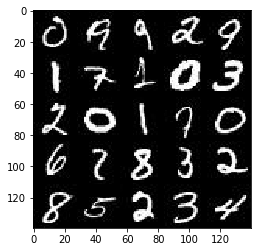

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

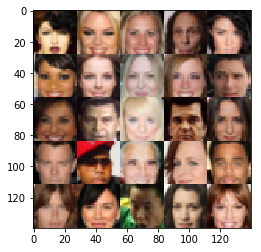

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        # No batch normalization on the input
        # discriminator uses leaky ReLU e.g. set alpha to 0.2 as recommended in DCGAN paper
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x128

        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        # Use batch normalization for discriminator (discriminator is not used other than training)
        bn2 = tf.layers.batch_normalization(x2, training=True)
        # discriminator uses leaky ReLU e.g. set alpha to 0.2 as recommended in DCGAN paper
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256

        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        # Use batch normalization for discriminator (discriminator is not used other than training)
        bn3 = tf.layers.batch_normalization(x3, training=True)
        # discriminator uses leaky ReLU e.g. set alpha to 0.2 as recommended in DCGAN paper
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x512
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.0 
    
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        # perform batch normalization during training
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        # generator uses ReLU e.g. set alpha to 0.0
        x1 = tf.maximum(alpha * x1, x1) 
        # 4x4x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        # perform batch normalization during training
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        # generator uses ReLU e.g. set alpha to 0.0
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now

        x3 = tf.layers.conv2d_transpose(x2, 64, 14, strides=2, padding='same')
        # perform batch normalization during training
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        # generator uses ReLU e.g. set alpha to 0.0
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now        

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now

        out = tf.tanh(logits)
        
        return out
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # make a generator model
    g_model = generator(input_z, out_channel_dim, is_train=True)
    # make a discriminator model and train on real images
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    # make a discriminator model and classify a generated output turn reuse on
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Create loss functions.
    # descriminator real prob = 1
    # descriminator fake (generated) prob = 0
    # generator fake (generated) prob = 1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    # descriminator loss is combnation of real and fake image performance.
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get variables to update during optimization 
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    """
     Optimize
     If we don't include the update ops as dependencies on the train step, the 
     tf.layers.batch_normalization layers won't update their population statistics,
     which will cause the model to fail at inference time
     https://github.com/udacity/deep-learning/blob/master/batch-norm/Batch_Normalization_Lesson.ipynb
    """
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):  
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    print(epoch_count, batch_size, z_dim, learning_rate, beta1, data_shape, data_image_mode)
    
    samples, losses = [], []
    steps = 0
    
    #print(data_shape, learning_rate)

    #tf.reset_default_graph()

    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                #print(batch_images.shape, input_real.shape)
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

        #saver.save(sess, './checkpoints/generator.ckpt')

    #with open('samples.pkl', 'wb') as f:
    #    pkl.dump(samples, f)
    
    return losses, samples               
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

2 32 100 0.0001 0.5 (60000, 28, 28, 1) L
Epoch 1/2... Discriminator Loss: 2.4719... Generator Loss: 0.2040
Epoch 1/2... Discriminator Loss: 4.3206... Generator Loss: 0.1351
Epoch 1/2... Discriminator Loss: 1.9646... Generator Loss: 0.5057
Epoch 1/2... Discriminator Loss: 1.0492... Generator Loss: 2.0618
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 1.2123
Epoch 1/2... Discriminator Loss: 0.8802... Generator Loss: 2.9495
Epoch 1/2... Discriminator Loss: 1.0458... Generator Loss: 1.5175
Epoch 1/2... Discriminator Loss: 1.5264... Generator Loss: 0.4522
Epoch 1/2... Discriminator Loss: 1.9996... Generator Loss: 0.2253
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 3.1168


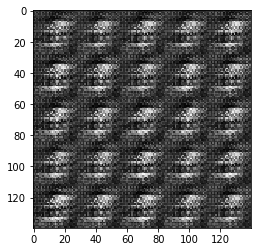

Epoch 1/2... Discriminator Loss: 0.8823... Generator Loss: 2.1731
Epoch 1/2... Discriminator Loss: 0.7198... Generator Loss: 1.3436
Epoch 1/2... Discriminator Loss: 3.6713... Generator Loss: 0.3183
Epoch 1/2... Discriminator Loss: 0.9965... Generator Loss: 1.3169
Epoch 1/2... Discriminator Loss: 0.9101... Generator Loss: 0.8135
Epoch 1/2... Discriminator Loss: 1.4706... Generator Loss: 0.8146
Epoch 1/2... Discriminator Loss: 1.1562... Generator Loss: 1.0664
Epoch 1/2... Discriminator Loss: 1.7783... Generator Loss: 0.4361
Epoch 1/2... Discriminator Loss: 1.5366... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.9864


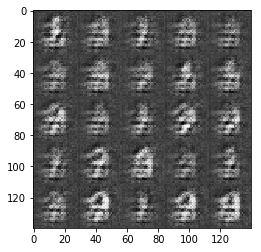

Epoch 1/2... Discriminator Loss: 2.0238... Generator Loss: 0.3091
Epoch 1/2... Discriminator Loss: 1.5414... Generator Loss: 0.3594
Epoch 1/2... Discriminator Loss: 1.2865... Generator Loss: 0.6591
Epoch 1/2... Discriminator Loss: 1.1027... Generator Loss: 0.6819
Epoch 1/2... Discriminator Loss: 1.0199... Generator Loss: 0.6317
Epoch 1/2... Discriminator Loss: 1.4582... Generator Loss: 0.3880
Epoch 1/2... Discriminator Loss: 1.1594... Generator Loss: 1.2635
Epoch 1/2... Discriminator Loss: 1.2267... Generator Loss: 1.8795
Epoch 1/2... Discriminator Loss: 1.4217... Generator Loss: 1.2598
Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 2.7878


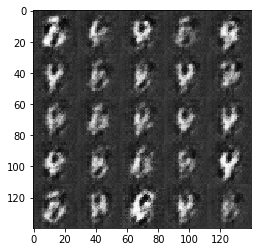

Epoch 1/2... Discriminator Loss: 1.0678... Generator Loss: 0.6986
Epoch 1/2... Discriminator Loss: 0.9084... Generator Loss: 1.3669
Epoch 1/2... Discriminator Loss: 0.9741... Generator Loss: 0.7664
Epoch 1/2... Discriminator Loss: 1.1584... Generator Loss: 0.5436
Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 1.9558
Epoch 1/2... Discriminator Loss: 1.0369... Generator Loss: 0.6753
Epoch 1/2... Discriminator Loss: 0.9761... Generator Loss: 1.2307
Epoch 1/2... Discriminator Loss: 1.6649... Generator Loss: 0.2750
Epoch 1/2... Discriminator Loss: 0.9650... Generator Loss: 1.7139
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 0.4156


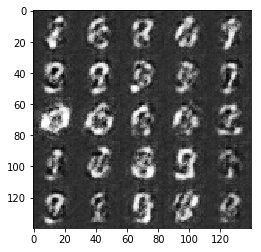

Epoch 1/2... Discriminator Loss: 1.1804... Generator Loss: 0.4263
Epoch 1/2... Discriminator Loss: 0.9891... Generator Loss: 0.6300
Epoch 1/2... Discriminator Loss: 1.0220... Generator Loss: 0.7153
Epoch 1/2... Discriminator Loss: 1.3371... Generator Loss: 0.4231
Epoch 1/2... Discriminator Loss: 0.6951... Generator Loss: 1.3145
Epoch 1/2... Discriminator Loss: 1.2608... Generator Loss: 0.4105
Epoch 1/2... Discriminator Loss: 0.9160... Generator Loss: 0.6815
Epoch 1/2... Discriminator Loss: 1.0437... Generator Loss: 0.6326
Epoch 1/2... Discriminator Loss: 1.0629... Generator Loss: 0.5813
Epoch 1/2... Discriminator Loss: 0.8919... Generator Loss: 0.7798


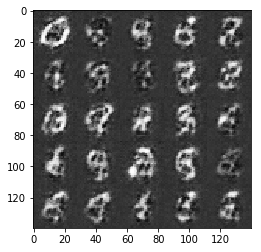

Epoch 1/2... Discriminator Loss: 1.4719... Generator Loss: 0.3341
Epoch 1/2... Discriminator Loss: 1.0425... Generator Loss: 2.6798
Epoch 1/2... Discriminator Loss: 0.7665... Generator Loss: 0.9962
Epoch 1/2... Discriminator Loss: 0.8158... Generator Loss: 0.7225
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 0.6227
Epoch 1/2... Discriminator Loss: 0.5146... Generator Loss: 1.7216
Epoch 1/2... Discriminator Loss: 0.7999... Generator Loss: 1.1866
Epoch 1/2... Discriminator Loss: 0.8264... Generator Loss: 0.7894
Epoch 1/2... Discriminator Loss: 0.4462... Generator Loss: 1.7552
Epoch 1/2... Discriminator Loss: 1.3243... Generator Loss: 0.3644


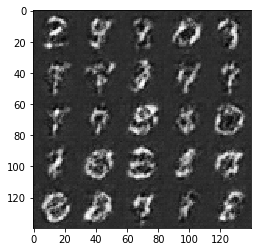

Epoch 1/2... Discriminator Loss: 0.7826... Generator Loss: 0.8405
Epoch 1/2... Discriminator Loss: 0.7861... Generator Loss: 0.8307
Epoch 1/2... Discriminator Loss: 1.6946... Generator Loss: 0.2451
Epoch 1/2... Discriminator Loss: 0.8251... Generator Loss: 0.8383
Epoch 1/2... Discriminator Loss: 1.4752... Generator Loss: 0.4846
Epoch 1/2... Discriminator Loss: 0.9307... Generator Loss: 0.6058
Epoch 1/2... Discriminator Loss: 1.0380... Generator Loss: 0.5440
Epoch 1/2... Discriminator Loss: 1.1383... Generator Loss: 0.4697
Epoch 1/2... Discriminator Loss: 0.9376... Generator Loss: 0.6489
Epoch 1/2... Discriminator Loss: 0.7870... Generator Loss: 0.7054


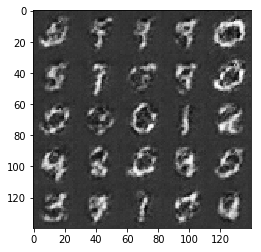

Epoch 1/2... Discriminator Loss: 0.9187... Generator Loss: 0.7180
Epoch 1/2... Discriminator Loss: 0.6576... Generator Loss: 0.9027
Epoch 1/2... Discriminator Loss: 1.0076... Generator Loss: 0.5768
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.3924
Epoch 1/2... Discriminator Loss: 0.7006... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 0.5573... Generator Loss: 1.0347
Epoch 1/2... Discriminator Loss: 1.5460... Generator Loss: 0.2818
Epoch 1/2... Discriminator Loss: 3.0023... Generator Loss: 4.0504
Epoch 1/2... Discriminator Loss: 1.1025... Generator Loss: 0.5275
Epoch 1/2... Discriminator Loss: 0.9932... Generator Loss: 0.5969


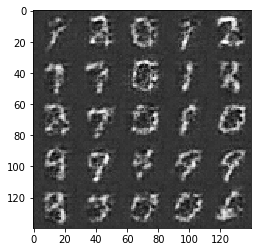

Epoch 1/2... Discriminator Loss: 0.9976... Generator Loss: 0.6545
Epoch 1/2... Discriminator Loss: 0.8027... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 0.9762... Generator Loss: 0.6023
Epoch 1/2... Discriminator Loss: 1.1403... Generator Loss: 0.4656
Epoch 1/2... Discriminator Loss: 0.4841... Generator Loss: 1.1982
Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 0.6443
Epoch 1/2... Discriminator Loss: 0.8977... Generator Loss: 0.6332
Epoch 1/2... Discriminator Loss: 1.3524... Generator Loss: 0.3792
Epoch 1/2... Discriminator Loss: 1.0177... Generator Loss: 0.5236
Epoch 1/2... Discriminator Loss: 1.4595... Generator Loss: 0.3087


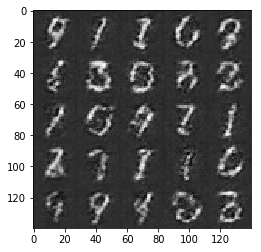

Epoch 1/2... Discriminator Loss: 0.8111... Generator Loss: 0.7217
Epoch 1/2... Discriminator Loss: 3.6059... Generator Loss: 0.0330
Epoch 1/2... Discriminator Loss: 1.1967... Generator Loss: 0.7723
Epoch 1/2... Discriminator Loss: 0.8429... Generator Loss: 0.7586
Epoch 1/2... Discriminator Loss: 1.1414... Generator Loss: 0.4836
Epoch 1/2... Discriminator Loss: 0.4374... Generator Loss: 1.3459
Epoch 1/2... Discriminator Loss: 0.8188... Generator Loss: 0.7161
Epoch 1/2... Discriminator Loss: 0.6179... Generator Loss: 0.9946
Epoch 1/2... Discriminator Loss: 0.8513... Generator Loss: 0.6472
Epoch 1/2... Discriminator Loss: 1.2673... Generator Loss: 0.3947


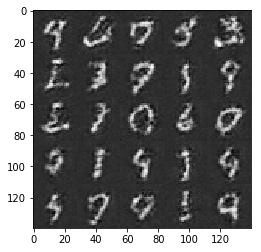

Epoch 1/2... Discriminator Loss: 1.4042... Generator Loss: 0.3339
Epoch 1/2... Discriminator Loss: 0.6932... Generator Loss: 0.8766
Epoch 1/2... Discriminator Loss: 1.2707... Generator Loss: 0.4064
Epoch 1/2... Discriminator Loss: 1.2171... Generator Loss: 0.4186
Epoch 1/2... Discriminator Loss: 0.9896... Generator Loss: 0.5418
Epoch 1/2... Discriminator Loss: 0.9995... Generator Loss: 0.5254
Epoch 1/2... Discriminator Loss: 1.1852... Generator Loss: 0.4345
Epoch 1/2... Discriminator Loss: 2.2615... Generator Loss: 0.1284
Epoch 1/2... Discriminator Loss: 1.6137... Generator Loss: 0.3559
Epoch 1/2... Discriminator Loss: 1.7444... Generator Loss: 0.2586


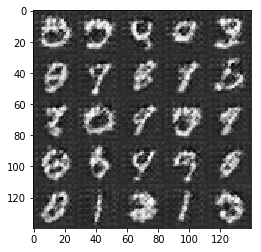

Epoch 1/2... Discriminator Loss: 1.2219... Generator Loss: 0.4544
Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 0.4910
Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 0.5622
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 0.4244
Epoch 1/2... Discriminator Loss: 0.8170... Generator Loss: 0.6917
Epoch 1/2... Discriminator Loss: 1.2311... Generator Loss: 0.4551
Epoch 1/2... Discriminator Loss: 1.2546... Generator Loss: 0.4170
Epoch 1/2... Discriminator Loss: 0.9744... Generator Loss: 0.5521
Epoch 1/2... Discriminator Loss: 1.3840... Generator Loss: 0.3725
Epoch 1/2... Discriminator Loss: 0.4013... Generator Loss: 1.3272


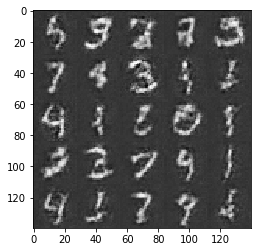

Epoch 1/2... Discriminator Loss: 0.9461... Generator Loss: 0.6141
Epoch 1/2... Discriminator Loss: 1.1998... Generator Loss: 0.4381
Epoch 1/2... Discriminator Loss: 1.2073... Generator Loss: 0.4963
Epoch 1/2... Discriminator Loss: 1.2670... Generator Loss: 0.4162
Epoch 1/2... Discriminator Loss: 1.5697... Generator Loss: 0.3032
Epoch 1/2... Discriminator Loss: 1.2480... Generator Loss: 0.4352
Epoch 1/2... Discriminator Loss: 1.3065... Generator Loss: 0.4034
Epoch 1/2... Discriminator Loss: 1.3534... Generator Loss: 0.3689
Epoch 1/2... Discriminator Loss: 1.2389... Generator Loss: 0.4303
Epoch 1/2... Discriminator Loss: 0.5054... Generator Loss: 1.1034


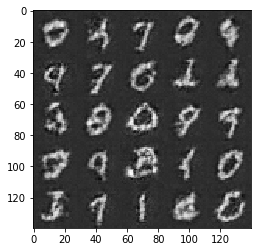

Epoch 1/2... Discriminator Loss: 0.1368... Generator Loss: 2.4354
Epoch 1/2... Discriminator Loss: 1.1840... Generator Loss: 0.4448
Epoch 1/2... Discriminator Loss: 2.6693... Generator Loss: 0.0942
Epoch 1/2... Discriminator Loss: 1.1748... Generator Loss: 0.5284
Epoch 1/2... Discriminator Loss: 1.1329... Generator Loss: 0.5304
Epoch 1/2... Discriminator Loss: 1.4231... Generator Loss: 0.3188
Epoch 1/2... Discriminator Loss: 1.1647... Generator Loss: 0.5042
Epoch 1/2... Discriminator Loss: 1.7247... Generator Loss: 0.2424
Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 0.5010
Epoch 1/2... Discriminator Loss: 1.3182... Generator Loss: 0.3956


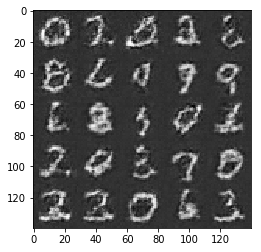

Epoch 1/2... Discriminator Loss: 0.8357... Generator Loss: 0.6941
Epoch 1/2... Discriminator Loss: 1.2609... Generator Loss: 0.3851
Epoch 1/2... Discriminator Loss: 0.7973... Generator Loss: 0.7624
Epoch 1/2... Discriminator Loss: 1.2758... Generator Loss: 0.3999
Epoch 1/2... Discriminator Loss: 1.2607... Generator Loss: 0.5066
Epoch 1/2... Discriminator Loss: 0.4628... Generator Loss: 1.2892
Epoch 1/2... Discriminator Loss: 0.7127... Generator Loss: 0.8850
Epoch 1/2... Discriminator Loss: 0.7721... Generator Loss: 0.7979
Epoch 1/2... Discriminator Loss: 0.4169... Generator Loss: 1.4406
Epoch 1/2... Discriminator Loss: 1.2331... Generator Loss: 0.4886


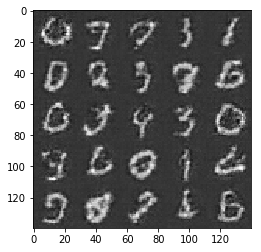

Epoch 1/2... Discriminator Loss: 1.4789... Generator Loss: 0.3099
Epoch 1/2... Discriminator Loss: 0.7352... Generator Loss: 0.8516
Epoch 1/2... Discriminator Loss: 0.2818... Generator Loss: 1.7301
Epoch 1/2... Discriminator Loss: 1.7435... Generator Loss: 0.2544
Epoch 1/2... Discriminator Loss: 1.7635... Generator Loss: 0.2422
Epoch 1/2... Discriminator Loss: 0.2000... Generator Loss: 4.2880
Epoch 1/2... Discriminator Loss: 2.8904... Generator Loss: 4.6135
Epoch 1/2... Discriminator Loss: 1.1254... Generator Loss: 0.8474
Epoch 1/2... Discriminator Loss: 1.1282... Generator Loss: 1.1725
Epoch 1/2... Discriminator Loss: 0.9756... Generator Loss: 0.8639


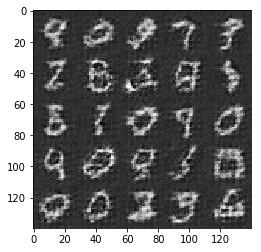

Epoch 1/2... Discriminator Loss: 2.1894... Generator Loss: 0.1483
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 0.5411
Epoch 1/2... Discriminator Loss: 1.0251... Generator Loss: 0.5708
Epoch 1/2... Discriminator Loss: 1.0718... Generator Loss: 0.5091
Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 0.6325
Epoch 1/2... Discriminator Loss: 0.5309... Generator Loss: 1.0458
Epoch 1/2... Discriminator Loss: 0.7372... Generator Loss: 0.7785
Epoch 1/2... Discriminator Loss: 1.1250... Generator Loss: 0.5197
Epoch 1/2... Discriminator Loss: 0.9964... Generator Loss: 0.5355
Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 0.4122


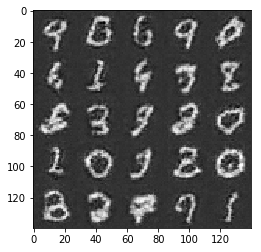

Epoch 1/2... Discriminator Loss: 1.3180... Generator Loss: 3.3438
Epoch 1/2... Discriminator Loss: 0.9751... Generator Loss: 2.3624
Epoch 1/2... Discriminator Loss: 1.1339... Generator Loss: 1.9498
Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 2.1059
Epoch 1/2... Discriminator Loss: 0.7884... Generator Loss: 0.8663
Epoch 1/2... Discriminator Loss: 0.7466... Generator Loss: 1.0139
Epoch 1/2... Discriminator Loss: 0.9314... Generator Loss: 0.5971
Epoch 1/2... Discriminator Loss: 1.4674... Generator Loss: 0.3231
Epoch 1/2... Discriminator Loss: 0.5603... Generator Loss: 1.1773
Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 2.3123


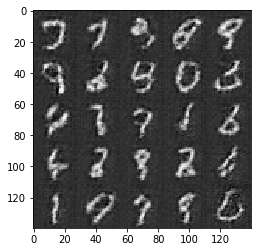

Epoch 1/2... Discriminator Loss: 0.9189... Generator Loss: 0.6777
Epoch 1/2... Discriminator Loss: 0.8354... Generator Loss: 0.7434
Epoch 1/2... Discriminator Loss: 0.7088... Generator Loss: 1.0282
Epoch 1/2... Discriminator Loss: 0.5736... Generator Loss: 1.1635
Epoch 1/2... Discriminator Loss: 0.9763... Generator Loss: 0.6221
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 0.5415
Epoch 1/2... Discriminator Loss: 1.2001... Generator Loss: 0.4220
Epoch 2/2... Discriminator Loss: 0.8781... Generator Loss: 0.6937
Epoch 2/2... Discriminator Loss: 1.5926... Generator Loss: 0.3262
Epoch 2/2... Discriminator Loss: 0.9080... Generator Loss: 0.6317


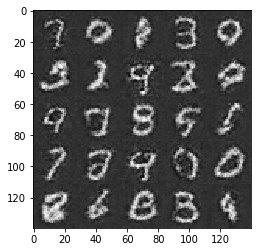

Epoch 2/2... Discriminator Loss: 0.8014... Generator Loss: 0.7055
Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 0.4088
Epoch 2/2... Discriminator Loss: 1.1637... Generator Loss: 0.4419
Epoch 2/2... Discriminator Loss: 1.1455... Generator Loss: 0.4635
Epoch 2/2... Discriminator Loss: 0.3033... Generator Loss: 1.6505
Epoch 2/2... Discriminator Loss: 1.0870... Generator Loss: 0.4994
Epoch 2/2... Discriminator Loss: 1.1513... Generator Loss: 0.4995
Epoch 2/2... Discriminator Loss: 1.7455... Generator Loss: 0.2501
Epoch 2/2... Discriminator Loss: 1.7226... Generator Loss: 0.2410
Epoch 2/2... Discriminator Loss: 0.9539... Generator Loss: 0.5812


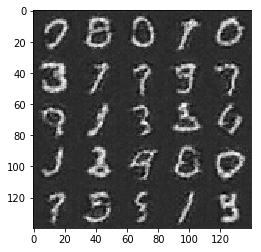

Epoch 2/2... Discriminator Loss: 0.3915... Generator Loss: 1.4881
Epoch 2/2... Discriminator Loss: 0.0769... Generator Loss: 3.1016
Epoch 2/2... Discriminator Loss: 0.9906... Generator Loss: 0.5552
Epoch 2/2... Discriminator Loss: 0.9925... Generator Loss: 0.5981
Epoch 2/2... Discriminator Loss: 1.4887... Generator Loss: 0.3052
Epoch 2/2... Discriminator Loss: 1.0373... Generator Loss: 0.5140
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 0.4719
Epoch 2/2... Discriminator Loss: 1.1521... Generator Loss: 0.4917
Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 0.7118
Epoch 2/2... Discriminator Loss: 1.5879... Generator Loss: 0.2998


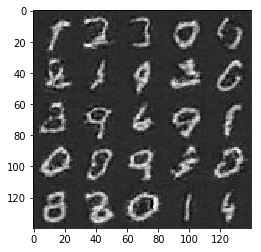

Epoch 2/2... Discriminator Loss: 0.5175... Generator Loss: 1.1375
Epoch 2/2... Discriminator Loss: 0.4839... Generator Loss: 1.1849
Epoch 2/2... Discriminator Loss: 1.2553... Generator Loss: 0.4087
Epoch 2/2... Discriminator Loss: 1.4125... Generator Loss: 0.3282
Epoch 2/2... Discriminator Loss: 1.4662... Generator Loss: 0.3403
Epoch 2/2... Discriminator Loss: 0.4117... Generator Loss: 1.3746
Epoch 2/2... Discriminator Loss: 0.5550... Generator Loss: 1.0578
Epoch 2/2... Discriminator Loss: 1.3916... Generator Loss: 0.3798
Epoch 2/2... Discriminator Loss: 2.0024... Generator Loss: 4.2643
Epoch 2/2... Discriminator Loss: 0.9953... Generator Loss: 1.6219


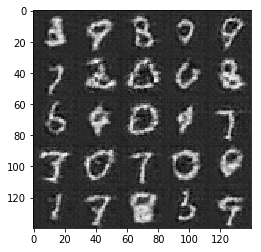

Epoch 2/2... Discriminator Loss: 0.5743... Generator Loss: 1.6471
Epoch 2/2... Discriminator Loss: 0.6722... Generator Loss: 1.9835
Epoch 2/2... Discriminator Loss: 0.3435... Generator Loss: 1.8872
Epoch 2/2... Discriminator Loss: 1.3807... Generator Loss: 0.3425
Epoch 2/2... Discriminator Loss: 0.3071... Generator Loss: 1.6897
Epoch 2/2... Discriminator Loss: 0.5520... Generator Loss: 1.0343
Epoch 2/2... Discriminator Loss: 1.3669... Generator Loss: 0.3703
Epoch 2/2... Discriminator Loss: 0.7916... Generator Loss: 0.7286
Epoch 2/2... Discriminator Loss: 0.8582... Generator Loss: 0.6708
Epoch 2/2... Discriminator Loss: 0.4846... Generator Loss: 1.1911


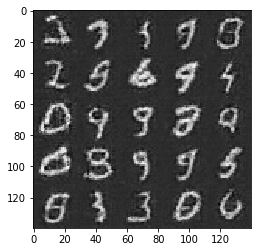

Epoch 2/2... Discriminator Loss: 1.0369... Generator Loss: 0.5230
Epoch 2/2... Discriminator Loss: 0.3054... Generator Loss: 1.6570
Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 0.4540
Epoch 2/2... Discriminator Loss: 0.2386... Generator Loss: 2.6104
Epoch 2/2... Discriminator Loss: 1.1260... Generator Loss: 2.4367
Epoch 2/2... Discriminator Loss: 0.6432... Generator Loss: 1.4808
Epoch 2/2... Discriminator Loss: 0.6808... Generator Loss: 1.4241
Epoch 2/2... Discriminator Loss: 0.7650... Generator Loss: 1.2300
Epoch 2/2... Discriminator Loss: 0.5435... Generator Loss: 2.6024
Epoch 2/2... Discriminator Loss: 0.7592... Generator Loss: 0.8188


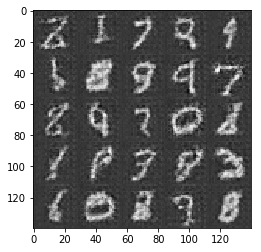

Epoch 2/2... Discriminator Loss: 1.3848... Generator Loss: 3.6949
Epoch 2/2... Discriminator Loss: 0.4544... Generator Loss: 2.1266
Epoch 2/2... Discriminator Loss: 0.3863... Generator Loss: 1.6295
Epoch 2/2... Discriminator Loss: 1.6737... Generator Loss: 0.2728
Epoch 2/2... Discriminator Loss: 0.5256... Generator Loss: 1.1252
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 0.4708
Epoch 2/2... Discriminator Loss: 1.1525... Generator Loss: 0.4858
Epoch 2/2... Discriminator Loss: 1.4393... Generator Loss: 0.3524
Epoch 2/2... Discriminator Loss: 1.3473... Generator Loss: 0.4025
Epoch 2/2... Discriminator Loss: 0.7422... Generator Loss: 0.8441


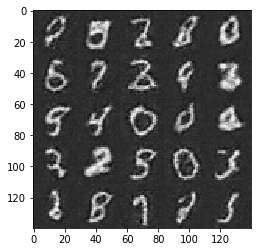

Epoch 2/2... Discriminator Loss: 0.9750... Generator Loss: 0.6262
Epoch 2/2... Discriminator Loss: 1.8325... Generator Loss: 0.2148
Epoch 2/2... Discriminator Loss: 1.1816... Generator Loss: 0.4584
Epoch 2/2... Discriminator Loss: 1.2358... Generator Loss: 0.4162
Epoch 2/2... Discriminator Loss: 0.8140... Generator Loss: 0.7782
Epoch 2/2... Discriminator Loss: 0.9122... Generator Loss: 0.7473
Epoch 2/2... Discriminator Loss: 0.4751... Generator Loss: 1.4524
Epoch 2/2... Discriminator Loss: 0.3678... Generator Loss: 2.7879
Epoch 2/2... Discriminator Loss: 0.5066... Generator Loss: 1.2676
Epoch 2/2... Discriminator Loss: 1.1752... Generator Loss: 0.4277


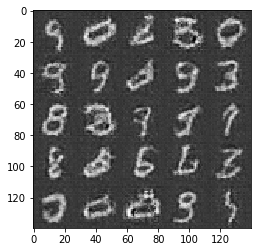

Epoch 2/2... Discriminator Loss: 0.7316... Generator Loss: 1.0672
Epoch 2/2... Discriminator Loss: 0.5186... Generator Loss: 1.1971
Epoch 2/2... Discriminator Loss: 0.4902... Generator Loss: 2.2302
Epoch 2/2... Discriminator Loss: 0.9512... Generator Loss: 0.6128
Epoch 2/2... Discriminator Loss: 0.9426... Generator Loss: 0.6343
Epoch 2/2... Discriminator Loss: 0.7119... Generator Loss: 0.8448
Epoch 2/2... Discriminator Loss: 0.8770... Generator Loss: 0.6593
Epoch 2/2... Discriminator Loss: 0.8697... Generator Loss: 0.6847
Epoch 2/2... Discriminator Loss: 1.4842... Generator Loss: 0.3039
Epoch 2/2... Discriminator Loss: 1.4243... Generator Loss: 0.3703


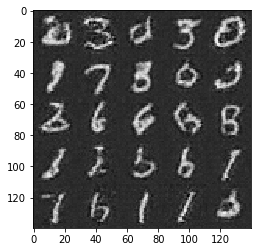

Epoch 2/2... Discriminator Loss: 1.5947... Generator Loss: 0.3002
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.3863
Epoch 2/2... Discriminator Loss: 1.1791... Generator Loss: 0.4643
Epoch 2/2... Discriminator Loss: 1.2008... Generator Loss: 0.4698
Epoch 2/2... Discriminator Loss: 1.2967... Generator Loss: 0.3918
Epoch 2/2... Discriminator Loss: 1.9500... Generator Loss: 0.1895
Epoch 2/2... Discriminator Loss: 0.4248... Generator Loss: 1.2778
Epoch 2/2... Discriminator Loss: 1.6374... Generator Loss: 0.2681
Epoch 2/2... Discriminator Loss: 1.5469... Generator Loss: 0.3002
Epoch 2/2... Discriminator Loss: 0.3848... Generator Loss: 1.4741


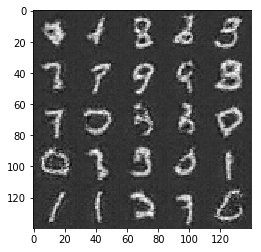

Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 0.6542
Epoch 2/2... Discriminator Loss: 0.5026... Generator Loss: 1.1910
Epoch 2/2... Discriminator Loss: 1.8673... Generator Loss: 0.2361
Epoch 2/2... Discriminator Loss: 1.6393... Generator Loss: 0.2864
Epoch 2/2... Discriminator Loss: 0.3533... Generator Loss: 3.1070
Epoch 2/2... Discriminator Loss: 3.8889... Generator Loss: 0.0474
Epoch 2/2... Discriminator Loss: 0.8990... Generator Loss: 1.0242
Epoch 2/2... Discriminator Loss: 0.8686... Generator Loss: 0.7208
Epoch 2/2... Discriminator Loss: 1.4804... Generator Loss: 0.3275
Epoch 2/2... Discriminator Loss: 1.0262... Generator Loss: 0.5428


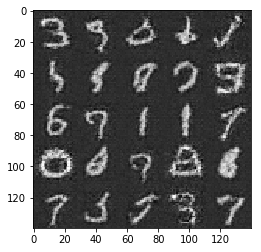

Epoch 2/2... Discriminator Loss: 0.9020... Generator Loss: 0.6329
Epoch 2/2... Discriminator Loss: 0.7823... Generator Loss: 0.8229
Epoch 2/2... Discriminator Loss: 1.7102... Generator Loss: 0.2338
Epoch 2/2... Discriminator Loss: 1.5354... Generator Loss: 0.3062
Epoch 2/2... Discriminator Loss: 1.6297... Generator Loss: 0.2774
Epoch 2/2... Discriminator Loss: 1.5719... Generator Loss: 0.3177
Epoch 2/2... Discriminator Loss: 1.6760... Generator Loss: 0.2717
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 0.4769
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 0.4168
Epoch 2/2... Discriminator Loss: 0.2197... Generator Loss: 2.0729


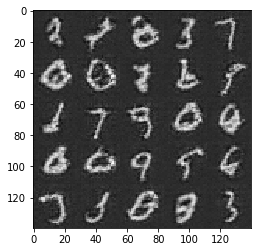

Epoch 2/2... Discriminator Loss: 1.5457... Generator Loss: 0.3202
Epoch 2/2... Discriminator Loss: 1.8367... Generator Loss: 0.2283
Epoch 2/2... Discriminator Loss: 1.1936... Generator Loss: 0.4630
Epoch 2/2... Discriminator Loss: 1.4063... Generator Loss: 0.3657
Epoch 2/2... Discriminator Loss: 1.3368... Generator Loss: 0.3915
Epoch 2/2... Discriminator Loss: 1.1504... Generator Loss: 0.4422
Epoch 2/2... Discriminator Loss: 2.2298... Generator Loss: 0.1456
Epoch 2/2... Discriminator Loss: 0.4837... Generator Loss: 1.4007
Epoch 2/2... Discriminator Loss: 1.7892... Generator Loss: 0.2346
Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 0.6487


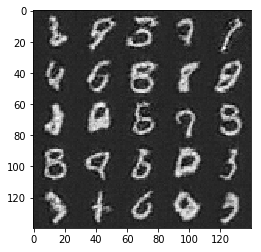

Epoch 2/2... Discriminator Loss: 0.3338... Generator Loss: 1.8368
Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 0.4708
Epoch 2/2... Discriminator Loss: 1.5199... Generator Loss: 0.3023
Epoch 2/2... Discriminator Loss: 1.9098... Generator Loss: 0.2384
Epoch 2/2... Discriminator Loss: 0.1496... Generator Loss: 2.5471
Epoch 2/2... Discriminator Loss: 1.5243... Generator Loss: 0.2865
Epoch 2/2... Discriminator Loss: 0.9628... Generator Loss: 0.6205
Epoch 2/2... Discriminator Loss: 1.8784... Generator Loss: 0.2343
Epoch 2/2... Discriminator Loss: 1.6255... Generator Loss: 0.2733
Epoch 2/2... Discriminator Loss: 1.1382... Generator Loss: 0.4982


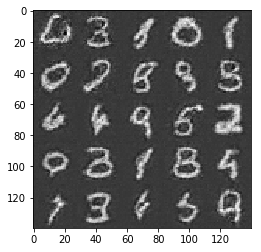

Epoch 2/2... Discriminator Loss: 1.7053... Generator Loss: 0.2738
Epoch 2/2... Discriminator Loss: 0.4482... Generator Loss: 1.3602
Epoch 2/2... Discriminator Loss: 1.4054... Generator Loss: 0.4309
Epoch 2/2... Discriminator Loss: 0.6772... Generator Loss: 0.8501
Epoch 2/2... Discriminator Loss: 0.5805... Generator Loss: 1.5196
Epoch 2/2... Discriminator Loss: 0.3974... Generator Loss: 1.5105
Epoch 2/2... Discriminator Loss: 0.5128... Generator Loss: 1.3008
Epoch 2/2... Discriminator Loss: 0.3833... Generator Loss: 1.7642
Epoch 2/2... Discriminator Loss: 0.8712... Generator Loss: 0.7607
Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 0.6117


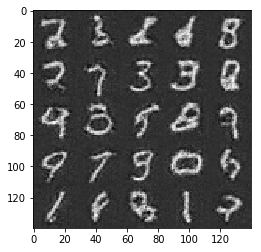

Epoch 2/2... Discriminator Loss: 0.2970... Generator Loss: 2.2605
Epoch 2/2... Discriminator Loss: 0.7446... Generator Loss: 0.9030
Epoch 2/2... Discriminator Loss: 1.2431... Generator Loss: 0.4607
Epoch 2/2... Discriminator Loss: 1.0517... Generator Loss: 0.5445
Epoch 2/2... Discriminator Loss: 1.7213... Generator Loss: 0.2664
Epoch 2/2... Discriminator Loss: 1.2498... Generator Loss: 0.4631
Epoch 2/2... Discriminator Loss: 0.6777... Generator Loss: 0.9033
Epoch 2/2... Discriminator Loss: 1.2392... Generator Loss: 0.4819
Epoch 2/2... Discriminator Loss: 0.9996... Generator Loss: 0.6263
Epoch 2/2... Discriminator Loss: 1.8079... Generator Loss: 0.2092


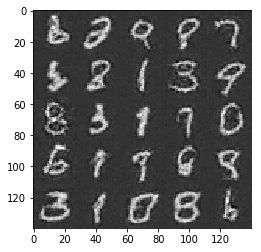

Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.4330
Epoch 2/2... Discriminator Loss: 0.0368... Generator Loss: 4.0324
Epoch 2/2... Discriminator Loss: 0.0595... Generator Loss: 4.2524
Epoch 2/2... Discriminator Loss: 0.8609... Generator Loss: 0.7168
Epoch 2/2... Discriminator Loss: 0.3354... Generator Loss: 3.6000
Epoch 2/2... Discriminator Loss: 2.9422... Generator Loss: 1.6151
Epoch 2/2... Discriminator Loss: 0.5383... Generator Loss: 1.4109
Epoch 2/2... Discriminator Loss: 0.4097... Generator Loss: 3.5496
Epoch 2/2... Discriminator Loss: 0.6740... Generator Loss: 2.5579
Epoch 2/2... Discriminator Loss: 0.4446... Generator Loss: 1.9208


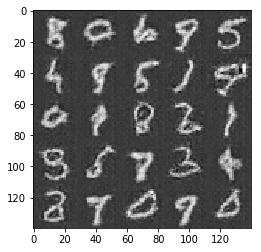

Epoch 2/2... Discriminator Loss: 0.4756... Generator Loss: 1.3133
Epoch 2/2... Discriminator Loss: 0.3687... Generator Loss: 1.5951
Epoch 2/2... Discriminator Loss: 0.5262... Generator Loss: 4.0730
Epoch 2/2... Discriminator Loss: 2.9316... Generator Loss: 0.1125
Epoch 2/2... Discriminator Loss: 0.6947... Generator Loss: 1.0947
Epoch 2/2... Discriminator Loss: 0.7139... Generator Loss: 0.9183
Epoch 2/2... Discriminator Loss: 1.4110... Generator Loss: 0.4369
Epoch 2/2... Discriminator Loss: 0.5241... Generator Loss: 1.1714
Epoch 2/2... Discriminator Loss: 1.3852... Generator Loss: 0.4187
Epoch 2/2... Discriminator Loss: 0.8437... Generator Loss: 0.8024


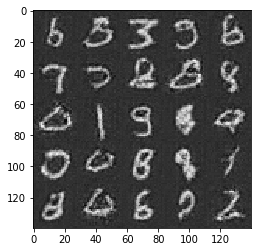

Epoch 2/2... Discriminator Loss: 0.7008... Generator Loss: 0.9600
Epoch 2/2... Discriminator Loss: 1.5596... Generator Loss: 0.2889
Epoch 2/2... Discriminator Loss: 1.2916... Generator Loss: 0.4081
Epoch 2/2... Discriminator Loss: 1.6866... Generator Loss: 0.2858
Epoch 2/2... Discriminator Loss: 1.5540... Generator Loss: 0.3123
Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 0.5054
Epoch 2/2... Discriminator Loss: 0.0575... Generator Loss: 3.6011
Epoch 2/2... Discriminator Loss: 1.1823... Generator Loss: 0.5264
Epoch 2/2... Discriminator Loss: 0.4267... Generator Loss: 1.4854
Epoch 2/2... Discriminator Loss: 1.6133... Generator Loss: 0.2741


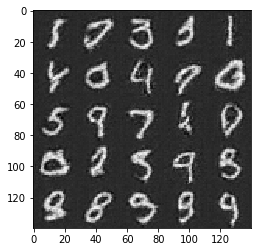

Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 0.5469
Epoch 2/2... Discriminator Loss: 0.6583... Generator Loss: 0.9567
Epoch 2/2... Discriminator Loss: 2.0275... Generator Loss: 0.1849
Epoch 2/2... Discriminator Loss: 1.4294... Generator Loss: 0.3646
Epoch 2/2... Discriminator Loss: 1.3443... Generator Loss: 0.4222


In [12]:
# Hyperparameters from the DCGAN paper https://arxiv.org/pdf/1511.06434.pdf Batch 128, Z_dim 100, 
# learning rate 0.0002 beta 0.5
#
# Experimenting with hyperparameters batch size seemed to matter...
# smaller batch size netted more stable loss batch to batch
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

1 32 100 0.0001 0.5 (202599, 28, 28, 3) RGB
Epoch 1/1... Discriminator Loss: 5.1890... Generator Loss: 0.0268
Epoch 1/1... Discriminator Loss: 4.6638... Generator Loss: 0.0698
Epoch 1/1... Discriminator Loss: 2.2910... Generator Loss: 0.4869
Epoch 1/1... Discriminator Loss: 2.1010... Generator Loss: 1.1211
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 0.8638... Generator Loss: 1.2197
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 1.5181
Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 2.5147
Epoch 1/1... Discriminator Loss: 0.6956... Generator Loss: 2.6872
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.5121


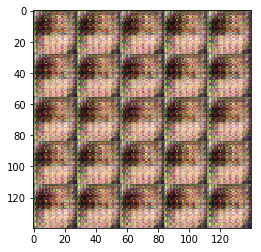

Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 1.1363
Epoch 1/1... Discriminator Loss: 0.4689... Generator Loss: 1.6970
Epoch 1/1... Discriminator Loss: 0.3629... Generator Loss: 1.8423
Epoch 1/1... Discriminator Loss: 0.6178... Generator Loss: 1.5475
Epoch 1/1... Discriminator Loss: 0.3667... Generator Loss: 2.3446
Epoch 1/1... Discriminator Loss: 1.7952... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 1.6535
Epoch 1/1... Discriminator Loss: 0.6369... Generator Loss: 1.4503
Epoch 1/1... Discriminator Loss: 0.4279... Generator Loss: 4.7673
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.6713


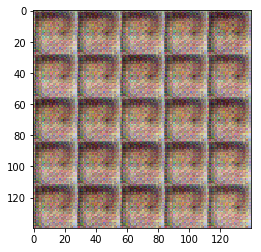

Epoch 1/1... Discriminator Loss: 2.6826... Generator Loss: 0.2643
Epoch 1/1... Discriminator Loss: 1.7500... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 1.6034... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 2.3410... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.6484... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.8872
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 0.9147


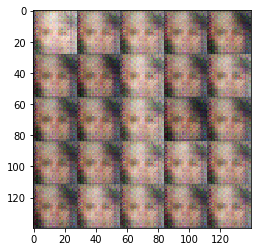

Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.5118
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.4582
Epoch 1/1... Discriminator Loss: 2.2594... Generator Loss: 0.5363
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 1.7522... Generator Loss: 0.4665


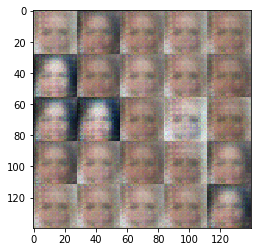

Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 2.0021... Generator Loss: 0.4415
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.8432
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.8260... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.5697
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.6306


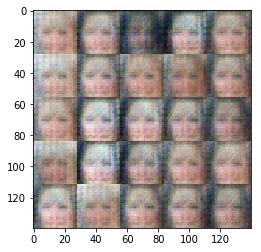

Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.6510... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.8762... Generator Loss: 0.4258
Epoch 1/1... Discriminator Loss: 2.0626... Generator Loss: 0.5454
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.7638... Generator Loss: 0.4745
Epoch 1/1... Discriminator Loss: 1.8111... Generator Loss: 0.4811


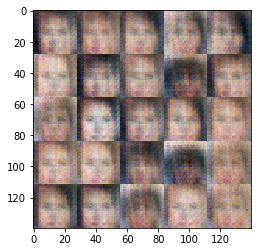

Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.7692... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.7604... Generator Loss: 0.4090
Epoch 1/1... Discriminator Loss: 1.7638... Generator Loss: 0.4826
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.2825... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6146


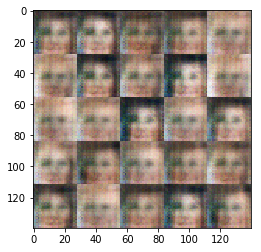

Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.9612... Generator Loss: 0.4816
Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.5719
Epoch 1/1... Discriminator Loss: 1.7066... Generator Loss: 0.4159
Epoch 1/1... Discriminator Loss: 1.6182... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.7724... Generator Loss: 0.5436


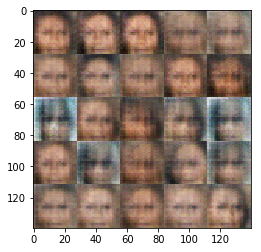

Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.5132... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.6725... Generator Loss: 0.4650
Epoch 1/1... Discriminator Loss: 1.6076... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.8769... Generator Loss: 0.4724
Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.5374
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.7118


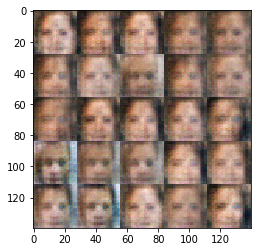

Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.7402... Generator Loss: 0.6394
Epoch 1/1... Discriminator Loss: 1.9936... Generator Loss: 0.4323
Epoch 1/1... Discriminator Loss: 1.4771... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.6560... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6547


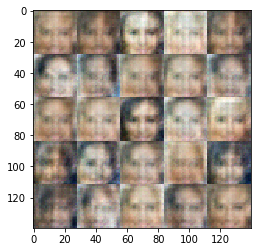

Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.6938
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.6054
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.6284... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.5884
Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.5179
Epoch 1/1... Discriminator Loss: 1.5368... Generator Loss: 0.6107


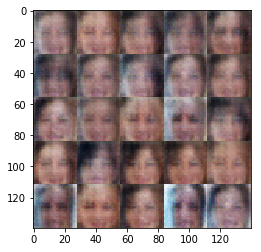

Epoch 1/1... Discriminator Loss: 1.5602... Generator Loss: 0.4910
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.7483... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.7886... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.6440... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.6896... Generator Loss: 0.4543


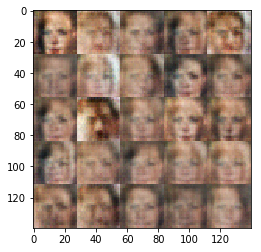

Epoch 1/1... Discriminator Loss: 1.6204... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.5642... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 1.1198
Epoch 1/1... Discriminator Loss: 1.8222... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.4849
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.6059... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.5760
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 0.5913


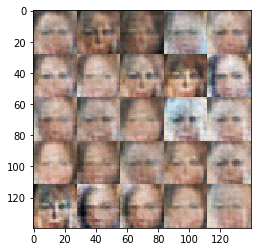

Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.5773... Generator Loss: 0.4143
Epoch 1/1... Discriminator Loss: 1.5593... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.5747
Epoch 1/1... Discriminator Loss: 1.6800... Generator Loss: 0.4547
Epoch 1/1... Discriminator Loss: 1.6186... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.5623... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 1.6479... Generator Loss: 0.5210


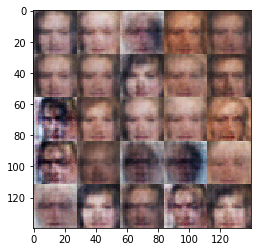

Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 1.5913... Generator Loss: 0.4281
Epoch 1/1... Discriminator Loss: 1.7448... Generator Loss: 0.4408
Epoch 1/1... Discriminator Loss: 1.7441... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.6614... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.6155... Generator Loss: 0.4726


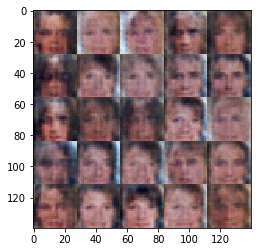

Epoch 1/1... Discriminator Loss: 1.7116... Generator Loss: 0.4482
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.5864... Generator Loss: 0.4642
Epoch 1/1... Discriminator Loss: 1.6767... Generator Loss: 0.4765
Epoch 1/1... Discriminator Loss: 1.5770... Generator Loss: 0.4155
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 1.7496... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 1.4665... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.7905... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.6173


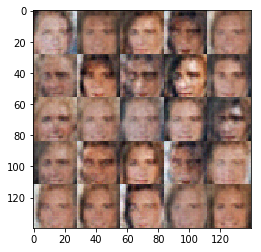

Epoch 1/1... Discriminator Loss: 1.7383... Generator Loss: 0.4631
Epoch 1/1... Discriminator Loss: 1.5512... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.5872... Generator Loss: 0.5024
Epoch 1/1... Discriminator Loss: 1.6057... Generator Loss: 0.4657
Epoch 1/1... Discriminator Loss: 1.5168... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.5792... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 1.6554... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.5857... Generator Loss: 0.4940
Epoch 1/1... Discriminator Loss: 1.5930... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.5887


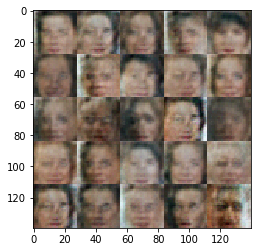

Epoch 1/1... Discriminator Loss: 1.5516... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 1.5149... Generator Loss: 0.5024
Epoch 1/1... Discriminator Loss: 1.7251... Generator Loss: 0.4846
Epoch 1/1... Discriminator Loss: 1.6204... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.4914
Epoch 1/1... Discriminator Loss: 1.6135... Generator Loss: 0.4780
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.7373... Generator Loss: 0.4458


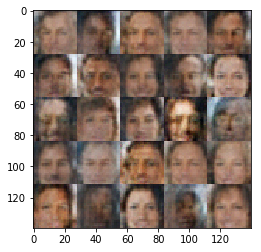

Epoch 1/1... Discriminator Loss: 1.4958... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.5816
Epoch 1/1... Discriminator Loss: 1.5708... Generator Loss: 0.5032
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 0.5376
Epoch 1/1... Discriminator Loss: 1.6404... Generator Loss: 0.4436
Epoch 1/1... Discriminator Loss: 1.6551... Generator Loss: 0.5211
Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.7872... Generator Loss: 0.4757


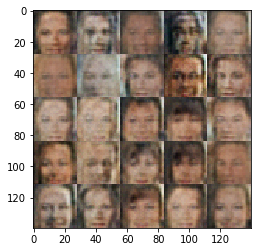

Epoch 1/1... Discriminator Loss: 1.7634... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.5933
Epoch 1/1... Discriminator Loss: 1.5678... Generator Loss: 0.5093
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.4951
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.4892
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.4514


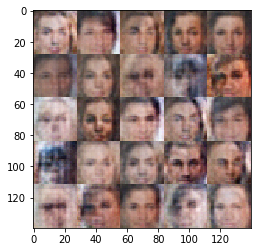

Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.5195... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 1.5749... Generator Loss: 0.5308
Epoch 1/1... Discriminator Loss: 1.5768... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.5611
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.5056
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.6036... Generator Loss: 0.4158
Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.6966


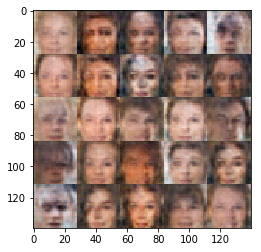

Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.4548
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.5407
Epoch 1/1... Discriminator Loss: 1.5406... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.5708... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.6948... Generator Loss: 0.5073
Epoch 1/1... Discriminator Loss: 1.6573... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 1.6980... Generator Loss: 0.4081
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 1.7297... Generator Loss: 0.3485


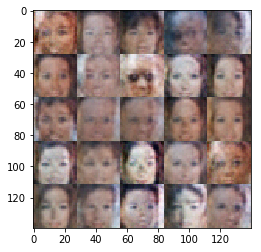

Epoch 1/1... Discriminator Loss: 1.5478... Generator Loss: 0.4865
Epoch 1/1... Discriminator Loss: 1.6003... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.5995
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.5876
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.6214... Generator Loss: 0.4123
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.6429


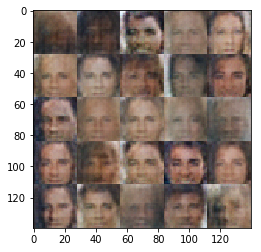

Epoch 1/1... Discriminator Loss: 1.5298... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.6234... Generator Loss: 0.4669
Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 1.5636... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.5418


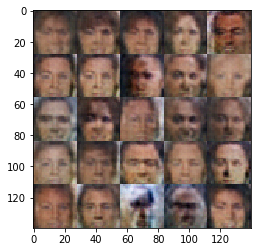

Epoch 1/1... Discriminator Loss: 1.5454... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 1.5531... Generator Loss: 0.4473
Epoch 1/1... Discriminator Loss: 1.6117... Generator Loss: 0.4279
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 1.6274... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.5058
Epoch 1/1... Discriminator Loss: 1.5859... Generator Loss: 0.4870
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6253


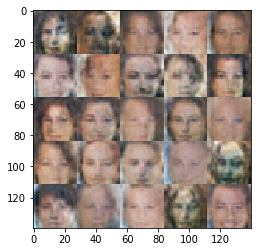

Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.5951
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.6090
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.5801... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.5770
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.5120


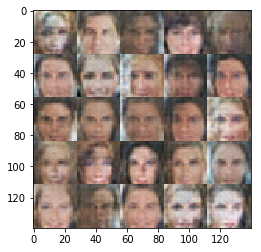

Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 0.5197
Epoch 1/1... Discriminator Loss: 1.6237... Generator Loss: 0.4048
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.5229
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.6003
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.4946


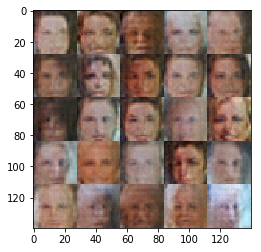

Epoch 1/1... Discriminator Loss: 1.5341... Generator Loss: 0.4553
Epoch 1/1... Discriminator Loss: 1.7691... Generator Loss: 0.3592
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.5551... Generator Loss: 0.4575
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.7070... Generator Loss: 0.3381
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.4739
Epoch 1/1... Discriminator Loss: 1.7240... Generator Loss: 0.3812
Epoch 1/1... Discriminator Loss: 1.7421... Generator Loss: 0.3941
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.6860


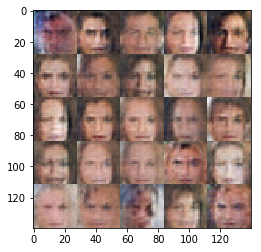

Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.3975
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.8201... Generator Loss: 0.2474
Epoch 1/1... Discriminator Loss: 1.5965... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.5907... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.5580


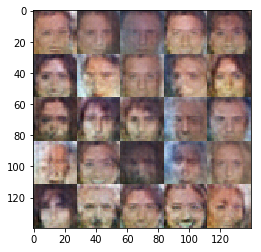

Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.5038... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.4287
Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.4760
Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.4803
Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 0.3857
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.5830
Epoch 1/1... Discriminator Loss: 1.6886... Generator Loss: 0.2923


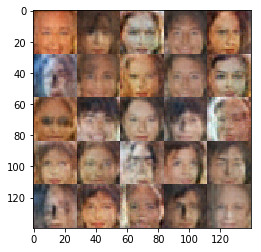

Epoch 1/1... Discriminator Loss: 1.6129... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.5818... Generator Loss: 0.3717
Epoch 1/1... Discriminator Loss: 1.6085... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.5588... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.5295


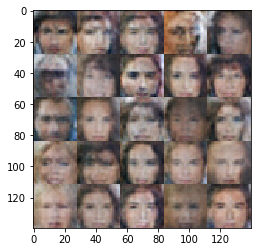

Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.6454... Generator Loss: 0.5290
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.5490... Generator Loss: 0.4515
Epoch 1/1... Discriminator Loss: 1.5554... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.6207... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 0.5353
Epoch 1/1... Discriminator Loss: 1.6881... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 1.6468... Generator Loss: 0.4837
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6232


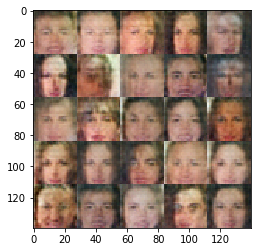

Epoch 1/1... Discriminator Loss: 1.6959... Generator Loss: 0.3889
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 1.6829... Generator Loss: 0.3148
Epoch 1/1... Discriminator Loss: 1.6115... Generator Loss: 0.3854
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.4666
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 1.0973
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.5111
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.4504
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.6571


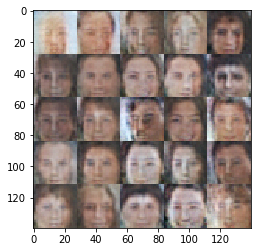

Epoch 1/1... Discriminator Loss: 1.7128... Generator Loss: 0.3799
Epoch 1/1... Discriminator Loss: 1.7962... Generator Loss: 0.2507
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.4917
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.4897
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 1.6288... Generator Loss: 0.4017
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.5865
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.4171


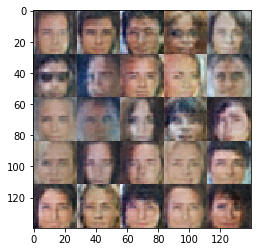

Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.4461... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.8453... Generator Loss: 0.3758
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.3408... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.5805
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.4594
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.7257


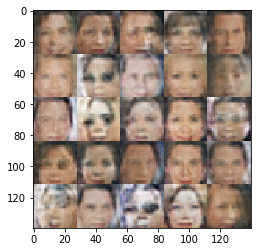

Epoch 1/1... Discriminator Loss: 1.5813... Generator Loss: 0.3538
Epoch 1/1... Discriminator Loss: 1.6007... Generator Loss: 0.3934
Epoch 1/1... Discriminator Loss: 1.6685... Generator Loss: 0.4411
Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.9055
Epoch 1/1... Discriminator Loss: 1.5902... Generator Loss: 0.4360
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 1.6293... Generator Loss: 0.3554


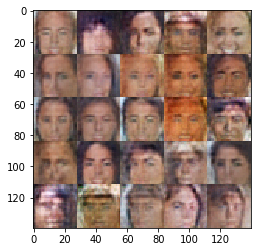

Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.9464... Generator Loss: 0.2643
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.4987
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.4563
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.4100
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.4161
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.4049


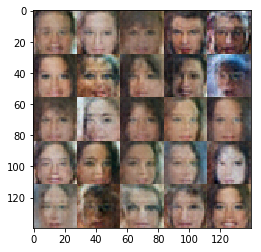

Epoch 1/1... Discriminator Loss: 1.6107... Generator Loss: 0.3490
Epoch 1/1... Discriminator Loss: 1.6277... Generator Loss: 0.3111
Epoch 1/1... Discriminator Loss: 1.6403... Generator Loss: 0.3414
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.3940
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.3429


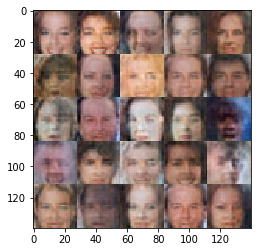

Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.4649
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.5276
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.5064
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.4249
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 1.2975
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 1.8825... Generator Loss: 0.2059
Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 0.7485


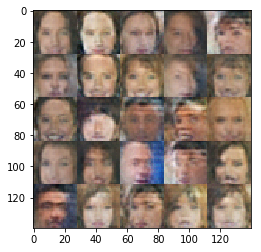

Epoch 1/1... Discriminator Loss: 1.3177... Generator Loss: 0.6032
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 1.0386
Epoch 1/1... Discriminator Loss: 1.6282... Generator Loss: 0.3554
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.4787
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 1.5615... Generator Loss: 0.3666
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.6100... Generator Loss: 0.3350
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.6222


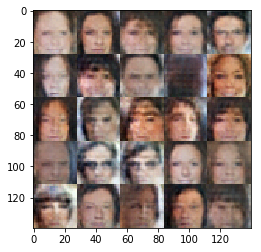

Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.9347
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.3606
Epoch 1/1... Discriminator Loss: 1.6451... Generator Loss: 0.2755
Epoch 1/1... Discriminator Loss: 1.6990... Generator Loss: 0.2891
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.5507
Epoch 1/1... Discriminator Loss: 1.5406... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.5534... Generator Loss: 0.3746
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.6320... Generator Loss: 0.3048


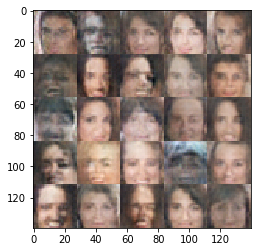

Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.4773
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.3411
Epoch 1/1... Discriminator Loss: 1.5970... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 1.6158... Generator Loss: 0.3302
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.3366
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 1.0986
Epoch 1/1... Discriminator Loss: 1.5575... Generator Loss: 0.4020


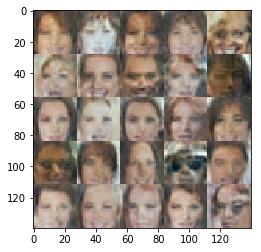

Epoch 1/1... Discriminator Loss: 1.6075... Generator Loss: 0.2990
Epoch 1/1... Discriminator Loss: 1.5650... Generator Loss: 0.4052
Epoch 1/1... Discriminator Loss: 2.0832... Generator Loss: 0.1967
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 1.7474... Generator Loss: 0.2815
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 1.3091


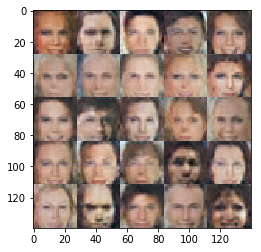

Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.5960
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.3970
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.4135
Epoch 1/1... Discriminator Loss: 1.5574... Generator Loss: 0.3374
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.4902
Epoch 1/1... Discriminator Loss: 1.7894... Generator Loss: 0.2477
Epoch 1/1... Discriminator Loss: 1.6899... Generator Loss: 0.3630
Epoch 1/1... Discriminator Loss: 1.6169... Generator Loss: 0.3450
Epoch 1/1... Discriminator Loss: 1.0211... Generator Loss: 0.9647
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.7756


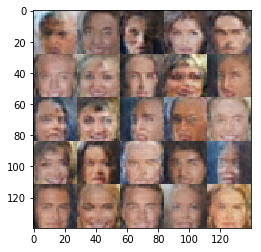

Epoch 1/1... Discriminator Loss: 1.9006... Generator Loss: 0.1976
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.8630
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 1.5112
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.4673
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.3211


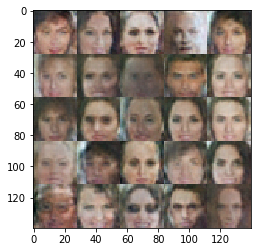

Epoch 1/1... Discriminator Loss: 1.6713... Generator Loss: 0.3235
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.5067
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.3070
Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.6380... Generator Loss: 0.3042
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.7306... Generator Loss: 0.2662
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.5432
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.9256... Generator Loss: 0.1861


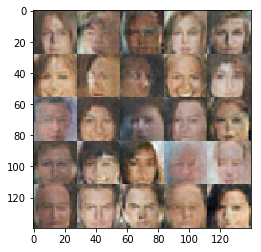

Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.4459
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.5919... Generator Loss: 0.2961
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.7993... Generator Loss: 0.2294
Epoch 1/1... Discriminator Loss: 0.8642... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.4167
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.5524


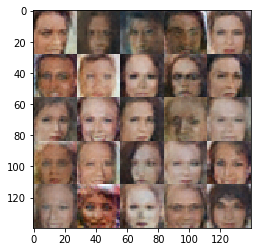

Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.3556
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 1.0785... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 0.3229
Epoch 1/1... Discriminator Loss: 1.4782... Generator Loss: 0.3704
Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 0.3101
Epoch 1/1... Discriminator Loss: 1.6081... Generator Loss: 0.3144
Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 0.3327
Epoch 1/1... Discriminator Loss: 1.9188... Generator Loss: 0.1889


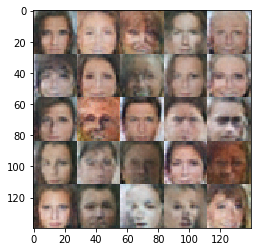

Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.8620... Generator Loss: 0.2118
Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.3099
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.3937
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.3433
Epoch 1/1... Discriminator Loss: 1.6046... Generator Loss: 0.2890
Epoch 1/1... Discriminator Loss: 2.0215... Generator Loss: 0.2214
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.5082
Epoch 1/1... Discriminator Loss: 1.1082... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 2.0569... Generator Loss: 0.1680


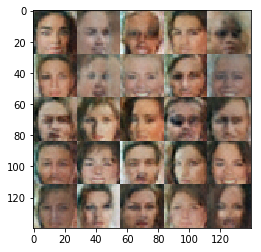

Epoch 1/1... Discriminator Loss: 1.6715... Generator Loss: 0.2893
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.4856
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.6204... Generator Loss: 0.2605
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.3211
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 1.6601... Generator Loss: 0.2413
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.6679... Generator Loss: 0.2665
Epoch 1/1... Discriminator Loss: 1.1238... Generator Loss: 0.6587


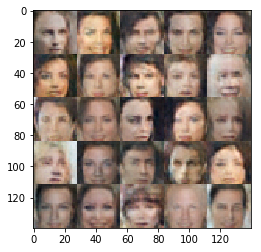

Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.4099
Epoch 1/1... Discriminator Loss: 1.2454... Generator Loss: 0.4630
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 0.5040
Epoch 1/1... Discriminator Loss: 0.7332... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 1.0710
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 2.2823
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.3432
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.3632
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 0.7891


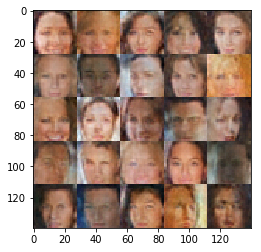

Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.6093... Generator Loss: 0.2916
Epoch 1/1... Discriminator Loss: 0.9171... Generator Loss: 1.7938
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.3457
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.4536
Epoch 1/1... Discriminator Loss: 1.1393... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 0.8051... Generator Loss: 0.8215


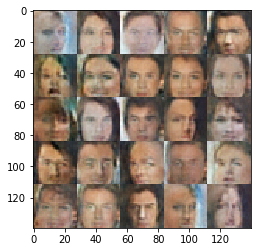

Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 1.6905... Generator Loss: 0.2512
Epoch 1/1... Discriminator Loss: 1.7757... Generator Loss: 0.2207
Epoch 1/1... Discriminator Loss: 1.6582... Generator Loss: 0.2706
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.5158
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.5350
Epoch 1/1... Discriminator Loss: 1.5427... Generator Loss: 0.2969
Epoch 1/1... Discriminator Loss: 1.6621... Generator Loss: 0.2582
Epoch 1/1... Discriminator Loss: 0.9801... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 0.7210


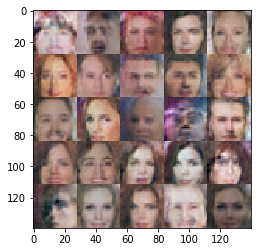

Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.7313... Generator Loss: 0.2425
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.5566
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.3503
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.4281
Epoch 1/1... Discriminator Loss: 1.5628... Generator Loss: 0.2922
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 1.1011
Epoch 1/1... Discriminator Loss: 1.8903... Generator Loss: 0.2046


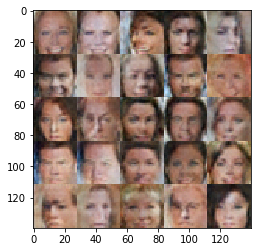

Epoch 1/1... Discriminator Loss: 1.8127... Generator Loss: 0.2323
Epoch 1/1... Discriminator Loss: 1.4916... Generator Loss: 0.3861
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.4019
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.4159
Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.3495
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.4193
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.3904


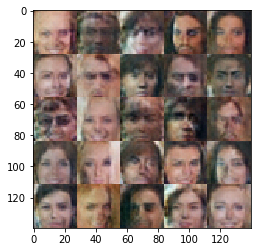

Epoch 1/1... Discriminator Loss: 1.6447... Generator Loss: 0.2949
Epoch 1/1... Discriminator Loss: 1.0114... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 0.7858... Generator Loss: 1.6968
Epoch 1/1... Discriminator Loss: 1.7107... Generator Loss: 0.2528
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.3078
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.3685
Epoch 1/1... Discriminator Loss: 1.0046... Generator Loss: 2.7016
Epoch 1/1... Discriminator Loss: 1.7719... Generator Loss: 0.2437


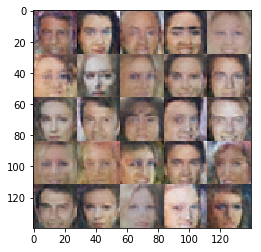

Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 1.1098
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 0.7283... Generator Loss: 2.0446
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.3635
Epoch 1/1... Discriminator Loss: 2.0361... Generator Loss: 0.1682
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.4295


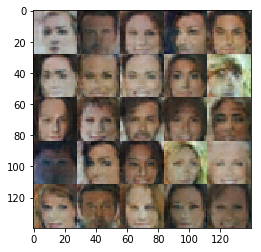

Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.4128
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.6054
Epoch 1/1... Discriminator Loss: 0.6324... Generator Loss: 2.3034
Epoch 1/1... Discriminator Loss: 1.2833... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 0.4290... Generator Loss: 1.8866
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.9558
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.0834
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.4260
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.5422


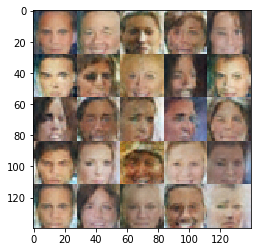

Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.3627
Epoch 1/1... Discriminator Loss: 1.0295... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.5759... Generator Loss: 0.3016
Epoch 1/1... Discriminator Loss: 1.0395... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.7541... Generator Loss: 0.2396
Epoch 1/1... Discriminator Loss: 1.8126... Generator Loss: 0.2203
Epoch 1/1... Discriminator Loss: 1.7684... Generator Loss: 0.2597
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.3679
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.3899
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.3601


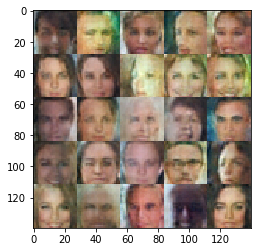

Epoch 1/1... Discriminator Loss: 1.8253... Generator Loss: 0.2400
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 0.7998
Epoch 1/1... Discriminator Loss: 1.6315... Generator Loss: 0.2586
Epoch 1/1... Discriminator Loss: 1.4992... Generator Loss: 0.3217
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.7514... Generator Loss: 0.2316
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.7016
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 1.6958
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.4426


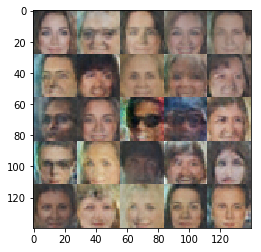

Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.4483
Epoch 1/1... Discriminator Loss: 1.7983... Generator Loss: 0.2049
Epoch 1/1... Discriminator Loss: 0.8165... Generator Loss: 1.1469
Epoch 1/1... Discriminator Loss: 1.6353... Generator Loss: 0.2787
Epoch 1/1... Discriminator Loss: 1.6755... Generator Loss: 0.2546
Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 2.1722
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.3475
Epoch 1/1... Discriminator Loss: 1.8024... Generator Loss: 0.3113
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.0305
Epoch 1/1... Discriminator Loss: 1.5910... Generator Loss: 0.2737


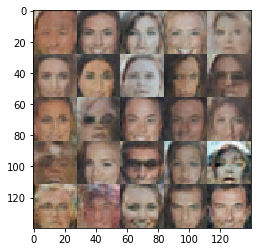

Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.8549... Generator Loss: 0.2000
Epoch 1/1... Discriminator Loss: 0.9841... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.0621... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 1.6612... Generator Loss: 0.3525
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 2.0893
Epoch 1/1... Discriminator Loss: 1.6034... Generator Loss: 0.2839
Epoch 1/1... Discriminator Loss: 1.7002... Generator Loss: 0.2655


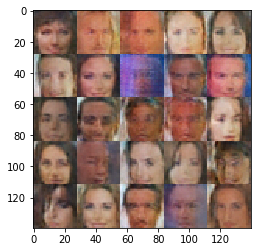

Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 2.1892... Generator Loss: 0.1377
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 3.1056
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.4556
Epoch 1/1... Discriminator Loss: 1.7594... Generator Loss: 0.2489
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.3642
Epoch 1/1... Discriminator Loss: 1.8910... Generator Loss: 0.2123
Epoch 1/1... Discriminator Loss: 1.6524... Generator Loss: 0.2718
Epoch 1/1... Discriminator Loss: 1.6827... Generator Loss: 0.3333


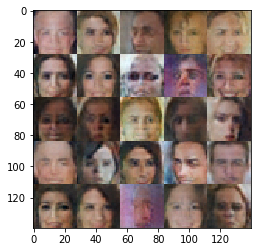

Epoch 1/1... Discriminator Loss: 0.5084... Generator Loss: 2.0661
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.4256
Epoch 1/1... Discriminator Loss: 0.7494... Generator Loss: 1.6020


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.